# Introduction
**Author: Samanyu**<br>
**Language: Python**<br>
**Accelerator: None**<br>

**OS: Windows 11 Home Single Language 64-bit**<br>
**CPU: Intel Core i7-10750H @ 2.60GHz**<br>
**RAM: 16.0GB DDR4 @ 1464MHz**<br>
**Graphics: NVIDIA GeForce GTX 1650 (4GB)**<br>

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

import keras as k
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,GlobalAveragePooling2D,Dense,Dropout,BatchNormalization,Activation
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-06-08 13:33:44.215557: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749389624.238284      84 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749389624.245221      84 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Reading Image data

In [2]:
data=r'/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets'
filepaths=[]
labels=[]
folds=os.listdir(data)

for fold in folds:
    foldpath=os.path.join(data,fold)
    flist=os.listdir(foldpath)
    for file in flist:
        filepath=os.path.join(foldpath,file)
        filepaths.append(filepath)
        labels.append(fold)
        
fil= pd.Series(filepaths, name='filepaths')
lab= pd.Series(labels, name='labels')
df=pd.concat([fil, lab], axis=1)

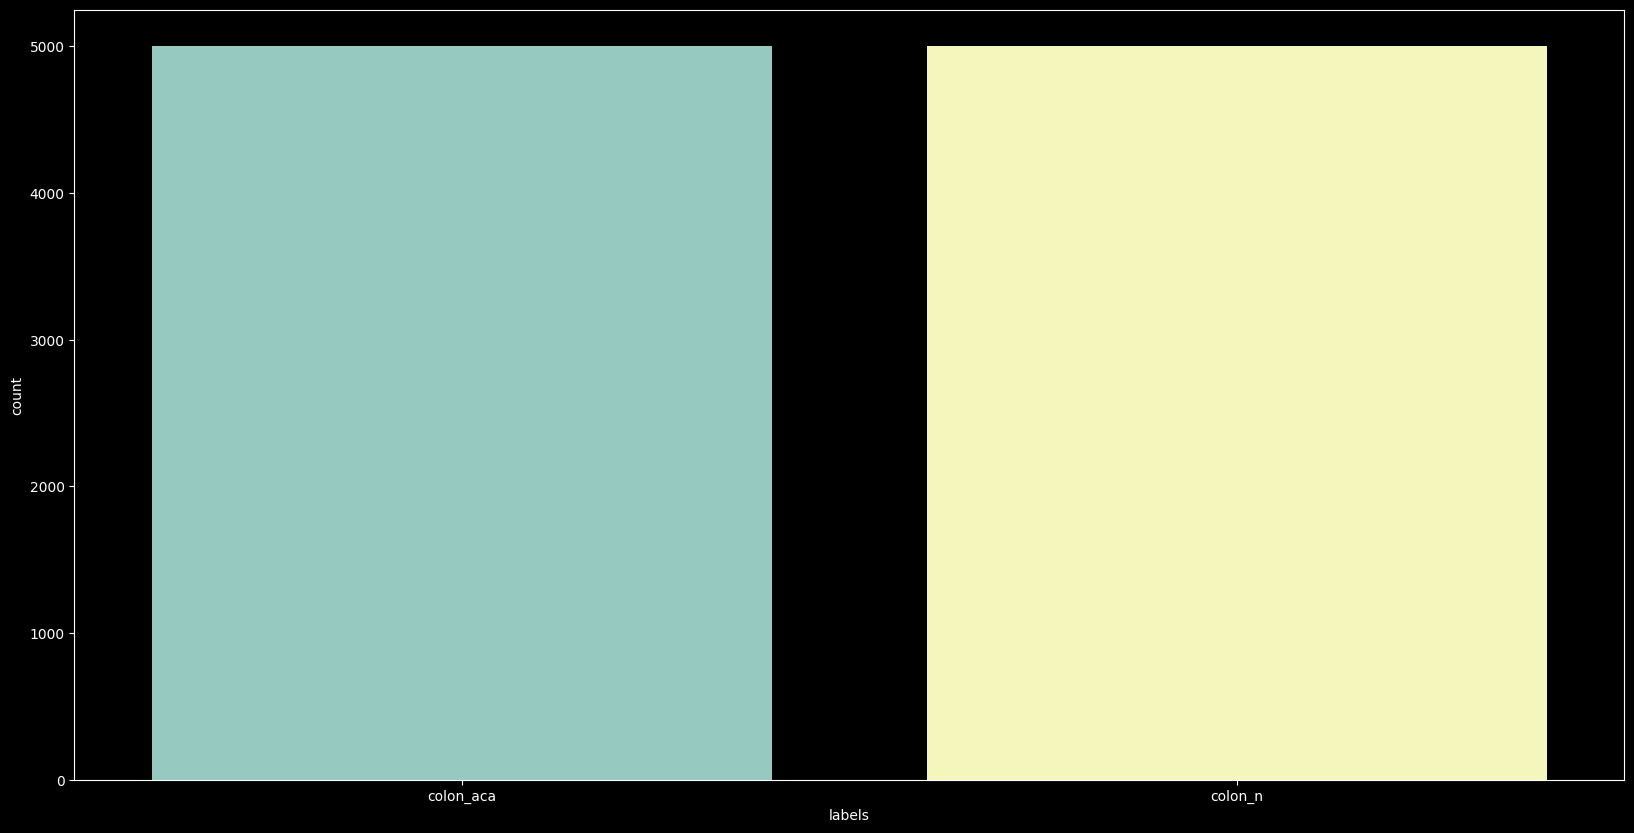

In [3]:
# Looking at the distribution of our image set
plt.style.use('dark_background')
plt.figure(figsize=(20,10))
sns.countplot(data=df,x='labels')
plt.show()

# Data Preparation

In [4]:
# Peefectly balanced
# Let us split the dataset
train,te=train_test_split(df,test_size=0.2,shuffle = True,random_state=20)
valid,test=train_test_split(te,test_size=0.5,shuffle = True,random_state=20)

In [5]:
traingen=ImageDataGenerator(rescale=1./255)
testgen=ImageDataGenerator(rescale=1./255)
validgen=ImageDataGenerator(rescale=1./255)
train=traingen.flow_from_dataframe(train,x_col= 'filepaths', y_col= 'labels', 
                                   target_size=(244,244), class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size=32)
test=testgen.flow_from_dataframe(test,x_col= 'filepaths', y_col= 'labels', 
                                   target_size=(244,244), class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size=32)
val=validgen.flow_from_dataframe(valid,x_col= 'filepaths', y_col= 'labels', 
                                   target_size=(244,244), class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size=32)

Found 8000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


# CNN Model

In [9]:
model=Sequential()

def Cnn(model):
    model.add(Conv2D(32,(3,3),input_shape=(244,244,3),padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    model.add(Conv2D(64,(3,3),padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())

    model.add(Conv2D(128,(3,3),padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))

    model.add(Conv2D(128,(3,3),padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))

    return model

def dense_layers(model):

    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    return model
    
model=Cnn(model)
model.add(GlobalAveragePooling2D())
model=dense_layers(model)

model.add(Dense(2, activation='softmax'))

opt = k.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 244, 244, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 244, 244, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 244, 244, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 244, 244, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 244, 244, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 244, 244, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 122, 122, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 122, 122, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 122, 122, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 122, 122, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 61, 61, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 61, 61, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 61, 61, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 61, 61, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 61, 61, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │         132,0

 Total params: 1,038,146 (3.96 MB)

 Trainable params: 1,033,858 (3.94 MB)

 Non-trainable params: 4,288 (16.75 KB)

In [10]:
es=EarlyStopping(monitor='val_loss', patience=25, verbose=1, restore_best_weights=True)
lr=ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=10, verbose=1, min_delta=0.0001)

callbacks_list=[es,lr]

In [11]:
history = model.fit(
    train,
    epochs=70,
    validation_data=val,
    callbacks=callbacks_list
)

Epoch 1/70


I0000 00:00:1749389740.647627     131 service.cc:148] XLA service 0x7c17f0002620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749389740.648406     131 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749389741.446819     131 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-08 13:35:48.716453: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,244,244]{3,2,1,0}, f32[32,64,244,244]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-06-08 13:35:49.163432: E external/l

  2/250 ━━━━━━━━━━━━━━━━━━━━ 24s 98ms/step - accuracy: 0.4453 - loss: 1.4048   

I0000 00:00:1749389754.257844     131 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 ━━━━━━━━━━━━━━━━━━━━ 163s 571ms/step - accuracy: 0.8484 - loss: 0.4074 - val_accuracy: 0.7150 - val_loss: 0.9766 - learning_rate: 0.0010
Epoch 2/70
250/250 ━━━━━━━━━━━━━━━━━━━━ 43s 170ms/step - accuracy: 0.9506 - loss: 0.1403 - val_accuracy: 0.8270 - val_loss: 0.4247 - learning_rate: 0.0010
Epoch 3/70
250/250 ━━━━━━━━━━━━━━━━━━━━ 45s 179ms/step - accuracy: 0.9770 - loss: 0.0636 - val_accuracy: 0.9510 - val_loss: 0.1507 - learning_rate: 0.0010
Epoch 4/70
250/250 ━━━━━━━━━━━━━━━━━━━━ 44s 175ms/step - accuracy: 0.9809 - loss: 0.0515 - val_accuracy: 0.5120 - val_loss: 6.1392 - learning_rate: 0.0010
Epoch 5/70
250/250 ━━━━━━━━━━━━━━━━━━━━ 44s 176ms/step - accuracy: 0.9850 - loss: 0.0442 - val_accuracy: 0.5120 - val_loss: 10.3189 - learning_rate: 0.0010
Epoch 6/70
250/250 ━━━━━━━━━━━━━━━━━━━━ 43s 173ms/step - accuracy: 0.9889 - loss: 0.0324 - val_accuracy: 0.5120 - val_loss: 7.7692 - learning_rate: 0.0010
Epoch 7/70
250/250 ━━━━━━━━━━━━━━━━━━━━ 44s 174ms/step - accuracy: 0.9883 - los

# Prediction

In [12]:
test_loss, test_accuracy = model.evaluate(test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 396ms/step - accuracy: 1.0000 - loss: 9.6367e-04


# Evaluation

In [13]:
pred_probs = model.predict(test)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test.classes
print("Classification Report\n\n")
print(classification_report(y_true, y_pred))

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 162ms/step
Classification Report


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       484
           1       1.00      1.00      1.00       516

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



Test Accuracy: 1.00


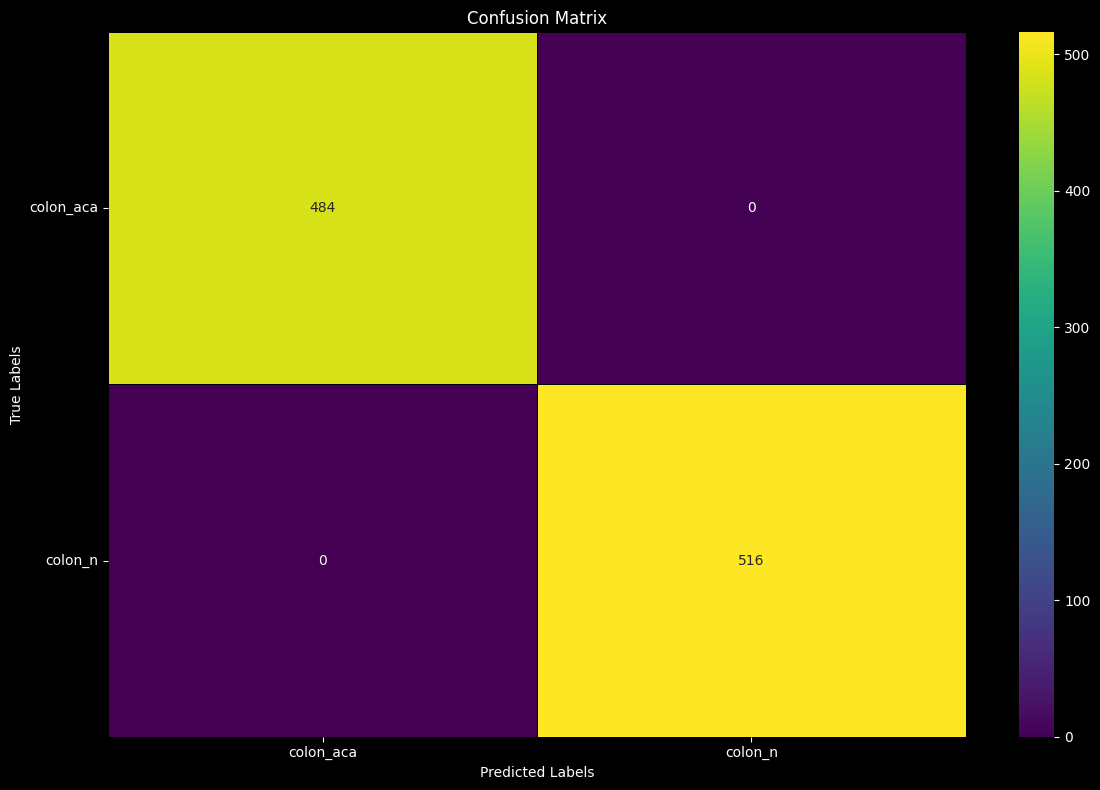

In [15]:
from sklearn.metrics import accuracy_score
test_accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

cm = confusion_matrix(y_true, y_pred)
labels = list(test.class_indices.keys())

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',
            xticklabels=labels, yticklabels=labels,
            linewidths=0.5, linecolor='black')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

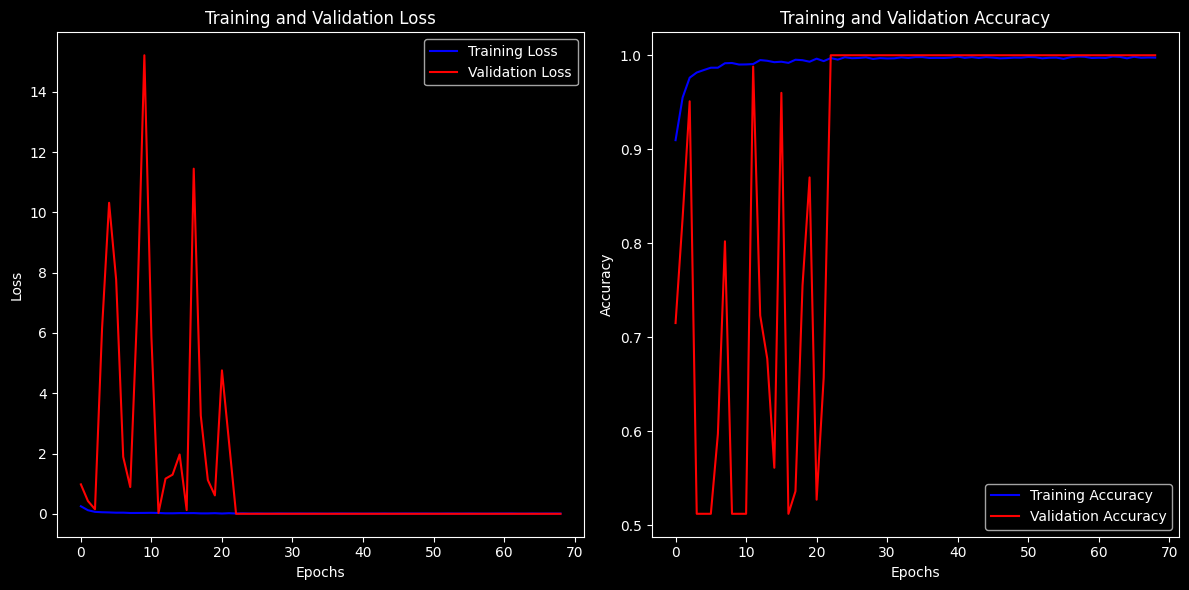

In [16]:
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Feedback and Suggestions

**Kindly provide feedback ans suggestions to improve the model**<br>

**Kindly Upvote if you likes this notebook or you found this helpful**